In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

from models.MLP import MLP

In [12]:
hidden_dim = 16
layers = 3
output_dim = 1
learning_rate = 0.00005
num_epochs = 4000
epochs_step = 10
batch_size = 32
test_size=0.3
dropout_rate = 0.5
pos_weight_ratio = 10
# ds_name = 'datasets/20220328-or-eng-shrink-full.csv'
ds_name = 'pre_processing/output2.csv'
train = True

In [13]:
data = pd.read_csv(ds_name)

# removed_cols = ['Postoperative Olanzapine', 'Postoperative Fluphenazine', 'Postoperative Flupentixol']
# data = data.drop(removed_cols, axis=1)

# 将特征和目标分开
features = data.drop('Label', axis=1).values
target = data['Label'].values

print(features.shape)
print(target.shape)

(1202, 27)
(1202,)


In [14]:
# 划分训练集和测试集
train_features, test_features, train_target, test_target = train_test_split(
    features, target, test_size=test_size, random_state=42)

In [15]:
# 将数据转换为PyTorch张量
train_features = torch.Tensor(train_features)
test_features = torch.Tensor(test_features)
train_target = torch.tensor(train_target, dtype=torch.float32).view(-1, 1)
test_target = torch.tensor(test_target, dtype=torch.float32).view(-1, 1)

train_dataset = TensorDataset(train_features, train_target)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

input_dim = train_features.shape[1]

In [16]:
# Random seed
torch.manual_seed(42)

model = MLP(input_dim, hidden_dim, output_dim,
            layers=layers, dropout_rate=dropout_rate)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

pos_weight = torch.tensor(
    (train_target == 0).sum() / (train_target == 1).sum(), dtype=torch.float32)
print(pos_weight)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight*pos_weight_ratio)
unratio_criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# To device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
torch.set_float32_matmul_precision('high')

model = model.to(device)
criterion = criterion.to(device)
unratio_criterion = unratio_criterion.to(device)

train_features = train_features.to(device)
test_features = test_features.to(device)
train_target = train_target.to(device)
test_target = test_target.to(device)

# Compile model
model = torch.compile(model)

/tmp/ipykernel_1782/2821676749.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_weight = torch.tensor(


tensor(18.1136)


In [17]:
def train_model(model, criterion, optimizer, num_epochs=100):
    train_losses = []
    test_losses = []
    sensitivities = []
    sppecificities = []
    best_model = None
    best_test_loss = 1000
    for epoch in tqdm(range(num_epochs)):
        model.train()

        if epoch == num_epochs // 2:
            criterion = nn.BCEWithLogitsLoss(
                pos_weight=pos_weight*pos_weight_ratio)
            criterion = criterion.to(device)

        train_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            # To device
            data = data.to(device)
            target = target.to(device)

            outputs = model(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # save model
        if (epoch + 1) % epochs_step == 0:
            # test
            train_loss /= len(train_loader)
            train_losses.append(train_loss)
            model.eval()
            outputs = model(test_features)
            test_loss = unratio_criterion(outputs, test_target)
            test_losses.append(test_loss.item())

            outputs = outputs > 0.5

            sensitivity = torch.sum(outputs[test_target == 1] == 1).item(
            ) / torch.sum(test_target == 1).item()
            sensitivities.append(sensitivity)

            sppecificity = torch.sum(outputs[test_target == 0] == 0).item(
            ) / torch.sum(test_target == 0).item()
            sppecificities.append(sppecificity)

            if test_loss < best_test_loss:
                best_test_loss = test_loss
                best_model = model

            # torch.save(model.state_dict(),
            #            'pths/MLP-epoch-{}-acc-{:.4f}-sens-{:.4f}.pth'.format(epoch+1, acc*100, sensitivity*100))
    
            if (epoch + 1) % (epochs_step*10)== 0:
                print('Epoch [{}/{}], Loss: {:.4f}, Test Loss: {:.4f}, Sensitivity: {:.4f}, Specificity: {:.4f}'
                    .format(epoch + 1, num_epochs, train_loss, test_loss.item(), sensitivity, sppecificity))
    
    return train_losses, test_losses, sensitivities, sppecificities, best_model, best_test_loss

Number of positive samples: 44
Number of negative samples: 797


  3%|▎         | 103/4000 [00:43<02:46, 23.37it/s] 

Epoch [100/4000], Loss: 6.0187, Test Loss: 1.4523, Sensitivity: 0.0000, Specificity: 1.0000


  5%|▌         | 205/4000 [00:47<02:30, 25.25it/s]

Epoch [200/4000], Loss: 4.0477, Test Loss: 1.8201, Sensitivity: 1.0000, Specificity: 0.0000


  8%|▊         | 304/4000 [00:51<02:38, 23.36it/s]

Epoch [300/4000], Loss: 3.2418, Test Loss: 2.0141, Sensitivity: 1.0000, Specificity: 0.0000


 10%|█         | 404/4000 [00:56<02:24, 24.87it/s]

Epoch [400/4000], Loss: 3.4366, Test Loss: 1.9991, Sensitivity: 1.0000, Specificity: 0.0000


 13%|█▎        | 503/4000 [01:00<02:23, 24.45it/s]

Epoch [500/4000], Loss: 3.5199, Test Loss: 1.9622, Sensitivity: 1.0000, Specificity: 0.0000


 15%|█▌        | 605/4000 [01:04<02:16, 24.90it/s]

Epoch [600/4000], Loss: 3.2193, Test Loss: 1.9411, Sensitivity: 1.0000, Specificity: 0.0000


 18%|█▊        | 704/4000 [01:09<02:28, 22.25it/s]

Epoch [700/4000], Loss: 3.1682, Test Loss: 1.9276, Sensitivity: 1.0000, Specificity: 0.0000


 20%|██        | 802/4000 [01:13<02:39, 20.07it/s]

Epoch [800/4000], Loss: 2.9818, Test Loss: 1.9243, Sensitivity: 1.0000, Specificity: 0.0000


 23%|██▎       | 904/4000 [01:18<01:56, 26.68it/s]

Epoch [900/4000], Loss: 2.9943, Test Loss: 1.9070, Sensitivity: 1.0000, Specificity: 0.0089


 25%|██▌       | 1003/4000 [01:21<02:01, 24.64it/s]

Epoch [1000/4000], Loss: 2.9910, Test Loss: 1.8604, Sensitivity: 1.0000, Specificity: 0.0801


 28%|██▊       | 1102/4000 [01:26<01:55, 25.02it/s]

Epoch [1100/4000], Loss: 3.0338, Test Loss: 1.8574, Sensitivity: 1.0000, Specificity: 0.1691


 30%|███       | 1204/4000 [01:30<02:06, 22.10it/s]

Epoch [1200/4000], Loss: 2.6813, Test Loss: 1.8099, Sensitivity: 1.0000, Specificity: 0.2582


 33%|███▎      | 1304/4000 [01:36<02:17, 19.62it/s]

Epoch [1300/4000], Loss: 2.7832, Test Loss: 1.7691, Sensitivity: 1.0000, Specificity: 0.3175


 35%|███▌      | 1403/4000 [01:40<01:50, 23.53it/s]

Epoch [1400/4000], Loss: 2.5725, Test Loss: 1.7306, Sensitivity: 1.0000, Specificity: 0.3561


 38%|███▊      | 1502/4000 [01:45<02:13, 18.68it/s]

Epoch [1500/4000], Loss: 2.6665, Test Loss: 1.6793, Sensitivity: 1.0000, Specificity: 0.3858


 40%|████      | 1603/4000 [01:49<01:31, 26.32it/s]

Epoch [1600/4000], Loss: 2.7312, Test Loss: 1.6138, Sensitivity: 0.9583, Specificity: 0.4273


 43%|████▎     | 1705/4000 [01:54<01:37, 23.65it/s]

Epoch [1700/4000], Loss: 2.5684, Test Loss: 1.5706, Sensitivity: 0.9583, Specificity: 0.4481


 45%|████▌     | 1804/4000 [01:58<01:43, 21.21it/s]

Epoch [1800/4000], Loss: 2.3266, Test Loss: 1.5353, Sensitivity: 0.9583, Specificity: 0.4718


 48%|████▊     | 1903/4000 [02:02<01:33, 22.38it/s]

Epoch [1900/4000], Loss: 2.2589, Test Loss: 1.4945, Sensitivity: 0.9167, Specificity: 0.4955


 50%|█████     | 2002/4000 [02:07<01:35, 20.91it/s]

Epoch [2000/4000], Loss: 2.4411, Test Loss: 1.4541, Sensitivity: 0.9167, Specificity: 0.5223


 53%|█████▎    | 2102/4000 [02:12<01:21, 23.17it/s]

Epoch [2100/4000], Loss: 2.3952, Test Loss: 1.4493, Sensitivity: 0.9167, Specificity: 0.5341


 55%|█████▌    | 2204/4000 [02:16<01:15, 23.76it/s]

Epoch [2200/4000], Loss: 2.1008, Test Loss: 1.4499, Sensitivity: 0.8333, Specificity: 0.5579


 58%|█████▊    | 2303/4000 [02:21<01:09, 24.26it/s]

Epoch [2300/4000], Loss: 2.1069, Test Loss: 1.4667, Sensitivity: 0.7917, Specificity: 0.5816


 60%|██████    | 2405/4000 [02:25<01:04, 24.55it/s]

Epoch [2400/4000], Loss: 2.0903, Test Loss: 1.4874, Sensitivity: 0.7500, Specificity: 0.5994


 63%|██████▎   | 2504/4000 [02:29<00:57, 25.89it/s]

Epoch [2500/4000], Loss: 2.4286, Test Loss: 1.5230, Sensitivity: 0.7500, Specificity: 0.6113


 65%|██████▌   | 2603/4000 [02:33<00:57, 24.31it/s]

Epoch [2600/4000], Loss: 2.0914, Test Loss: 1.5546, Sensitivity: 0.7500, Specificity: 0.6142


 68%|██████▊   | 2702/4000 [02:38<01:10, 18.38it/s]

Epoch [2700/4000], Loss: 2.0710, Test Loss: 1.6147, Sensitivity: 0.7500, Specificity: 0.6291


 70%|███████   | 2802/4000 [02:42<01:09, 17.24it/s]

Epoch [2800/4000], Loss: 2.0648, Test Loss: 1.6663, Sensitivity: 0.7083, Specificity: 0.6380


 73%|███████▎  | 2904/4000 [02:47<00:42, 25.57it/s]

Epoch [2900/4000], Loss: 1.7805, Test Loss: 1.7370, Sensitivity: 0.7083, Specificity: 0.6528


 75%|███████▌  | 3004/4000 [02:51<00:45, 21.91it/s]

Epoch [3000/4000], Loss: 1.9471, Test Loss: 1.8357, Sensitivity: 0.7083, Specificity: 0.6617


 78%|███████▊  | 3103/4000 [02:56<00:41, 21.71it/s]

Epoch [3100/4000], Loss: 1.8215, Test Loss: 1.9104, Sensitivity: 0.7083, Specificity: 0.6766


 80%|████████  | 3204/4000 [03:02<00:40, 19.49it/s]

Epoch [3200/4000], Loss: 1.6971, Test Loss: 2.0013, Sensitivity: 0.7083, Specificity: 0.6914


 83%|████████▎ | 3303/4000 [03:06<00:31, 21.99it/s]

Epoch [3300/4000], Loss: 1.7396, Test Loss: 2.1750, Sensitivity: 0.6667, Specificity: 0.7122


 85%|████████▌ | 3402/4000 [03:11<00:25, 23.08it/s]

Epoch [3400/4000], Loss: 1.7166, Test Loss: 2.3362, Sensitivity: 0.6667, Specificity: 0.7151


 88%|████████▊ | 3503/4000 [03:15<00:23, 21.37it/s]

Epoch [3500/4000], Loss: 1.6381, Test Loss: 2.5283, Sensitivity: 0.6667, Specificity: 0.7300


 90%|█████████ | 3602/4000 [03:20<00:18, 21.70it/s]

Epoch [3600/4000], Loss: 1.7542, Test Loss: 2.6637, Sensitivity: 0.6250, Specificity: 0.7359


 93%|█████████▎| 3704/4000 [03:25<00:14, 20.55it/s]

Epoch [3700/4000], Loss: 1.6501, Test Loss: 2.9144, Sensitivity: 0.6250, Specificity: 0.7507


 95%|█████████▌| 3802/4000 [03:30<00:09, 20.67it/s]

Epoch [3800/4000], Loss: 1.6370, Test Loss: 3.1661, Sensitivity: 0.6250, Specificity: 0.7626


 98%|█████████▊| 3904/4000 [03:34<00:04, 22.95it/s]

Epoch [3900/4000], Loss: 1.7928, Test Loss: 3.3461, Sensitivity: 0.6250, Specificity: 0.7656


100%|██████████| 4000/4000 [03:39<00:00, 18.26it/s]


Epoch [4000/4000], Loss: 1.6450, Test Loss: 3.6468, Sensitivity: 0.5833, Specificity: 0.7864


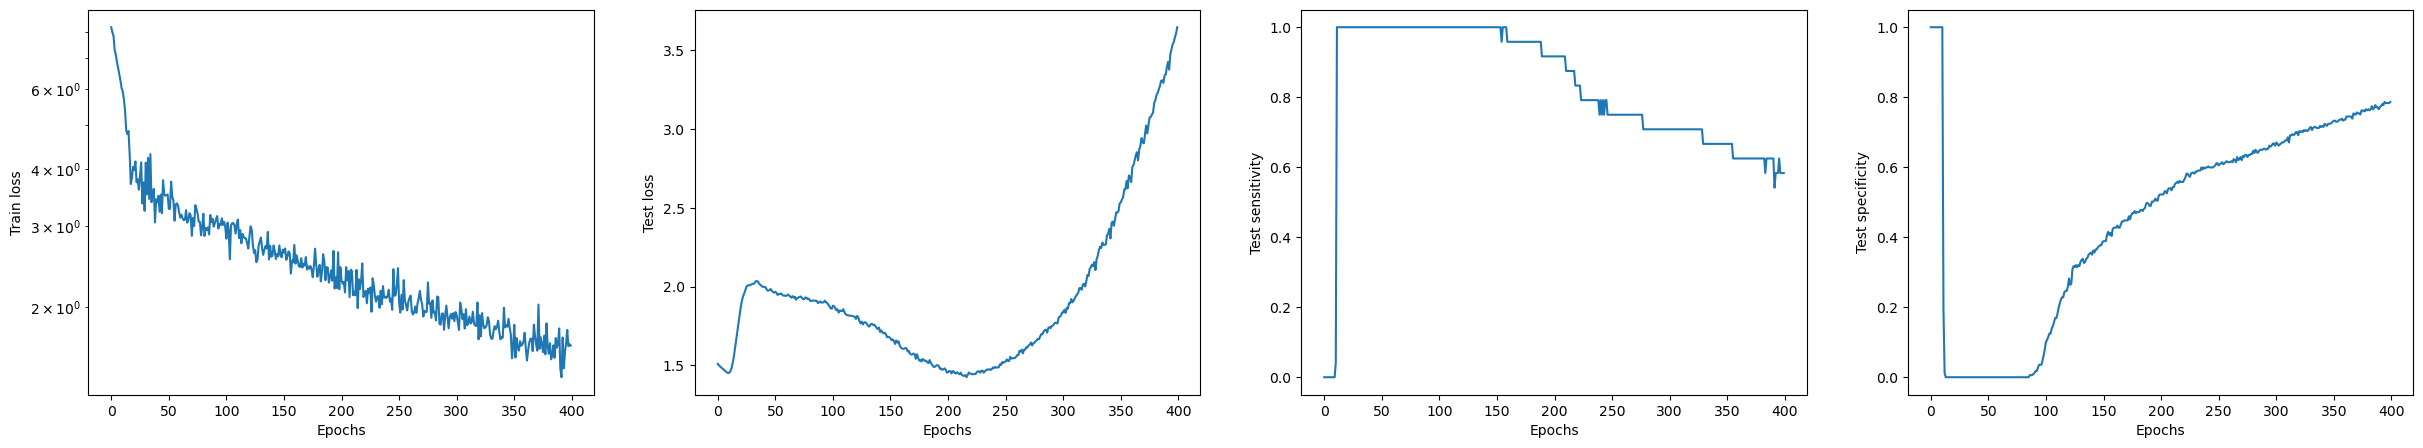

In [18]:
if train == True:
    # torch._dynamo.config.suppress_errors = True

    # Count number of positive and negative samples
    print('Number of positive samples: {}'.format((train_target == 1).sum()))
    print('Number of negative samples: {}'.format((train_target == 0).sum()))

    train_losses, test_losses, sensitivities, sppecificities, model, best_test_loss = train_model(
        model, criterion, optimizer, num_epochs=num_epochs)

    # Plot losses and accuracies separately
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(30, 5))
    ax[0].plot(train_losses)
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Train loss')
    ax[0].set_yscale('log')
    ax[1].plot(test_losses)
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Test loss')
    ax[2].plot(sensitivities)
    ax[2].set_xlabel('Epochs')
    ax[2].set_ylabel('Test sensitivity')
    ax[3].plot(sppecificities)
    ax[3].set_xlabel('Epochs')
    ax[3].set_ylabel('Test specificity')
    
    plt.savefig('outputs/MLP-{:04}-{:02.4f}.png'.format(num_epochs, test_losses[-1]*100))
    plt.show()

    torch.save(model.state_dict(), 'pths/MLP-epoch-{}-acc-{:.4f}.pth'.format(num_epochs, best_test_loss*100))

In [19]:
def test_model(model, features, target):
    # Test in all data
    model.eval()
    outputs = model(features)
    outputs = outputs > 0.5

    # Reshape
    outputs = outputs.view(-1)
    target = target.view(-1)
    success = torch.sum(outputs == target).item()
    print('Success: {}/{}'.format(success, len(target)))

    acc = success / len(target)
    print('Accuracy: {:.2f}'.format(acc))

    # Confusion matrix
    TP = torch.sum((outputs == 1) & (target == 1)).item()
    TN = torch.sum((outputs == 0) & (target == 0)).item()
    FP = torch.sum((outputs == 1) & (target == 0)).item()
    FN = torch.sum((outputs == 0) & (target == 1)).item()

    print('TP: {}, TN: {}, FP: {}, FN: {}'.format(TP, TN, FP, FN))

    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    print('Sensitivity: {:.2f}, Specificity: {:.2f}'.format(sensitivity, specificity))

In [20]:
# Load model
# model.load_state_dict(torch.load('pths/MLP-500-9.5580e-01.pth'))

print('In test set:')
test_model(model, test_features, test_target)

print('\nIn all data:')
test_model(model, torch.Tensor(features).to(device), torch.Tensor(target).to(device))

In test set:
Success: 279/361
Accuracy: 0.77
TP: 14, TN: 265, FP: 72, FN: 10
Sensitivity: 0.58, Specificity: 0.79

In all data:
Success: 961/1202
Accuracy: 0.80
TP: 58, TN: 903, FP: 231, FN: 10
Sensitivity: 0.85, Specificity: 0.80
